# Example 2

This is an implementation of the second order problem in Sec. 4.3.2 of the paper

    M Mortensen, "A generic and strictly banded spectral Petrov-Galerkin method for differential equations with polynomial coefficients"
    

# Helmholtz equation

The Helmholtz Dirichlet problem is described as

$$
u''(x) - \mu u(x) = f(x), \quad u(\pm 1) = 0,  x \in [-1, 1]
$$

where $\mu \ge 0$ is a constant, $f(x)$ is some right hand side function and $u(x)$ is the solution. For the solution we will use ultraspherical polynomials $Q^{(\alpha)}_n(x)$ defined in [Examples](Examples.ipynb).

We solve the Helmholtz equation with a Petrov-Galerkin method and use for the trial function space $S=\text{span}\{Q^{(\alpha)}_n-Q^{(\alpha)}_{n+2}\}_{n=0}^{N-2} \in \text{P}_N$, where $\text{P}_N$ is the set of polynomials of order less than or equal to $N$. For the test space we use $V=\text{span}\left\{\phi^{(2)}_n\right\}_{n=0}^{N-2}$, also defined in [Examples](Examples.ipynb).

The method is to find $u \in S$ such that

$$
(u'', v)_{\omega^{\alpha}} - \mu(u, v)_{\omega^{\alpha}} = (f, v)_{\omega^{\alpha}}, \quad \text{for all } v \in V
$$

We start by importing shenfun's functionality, and specify some parameters with obvious meaning.

In [1]:
from shenfun import *
import matplotlib.pyplot as plt

N = 60
mu = 1

Choose family of polynomials by uncommenting only one of the following four lines.

In [2]:
family = 'Ultraspherical'; kw = {'alpha': 1}
#family = 'Legendre'; kw = {}
#family = 'Chebyshev'; kw = {}
#family = 'ChebyshevU'; kw = {}

Create function spaces and test and trial functions. Assemble the coefficient matrix A, that will consist of both mass and stiffness matrices.

In [3]:
S = FunctionSpace(N, family, bc=(0, 0), **kw)
V = FunctionSpace(N+2, family, basis='Phi2', **kw)
u = TrialFunction(S)
v = TestFunction(V)
A = inner(v, div(grad(u)) - mu*u)

<IPython.core.display.Javascript object>


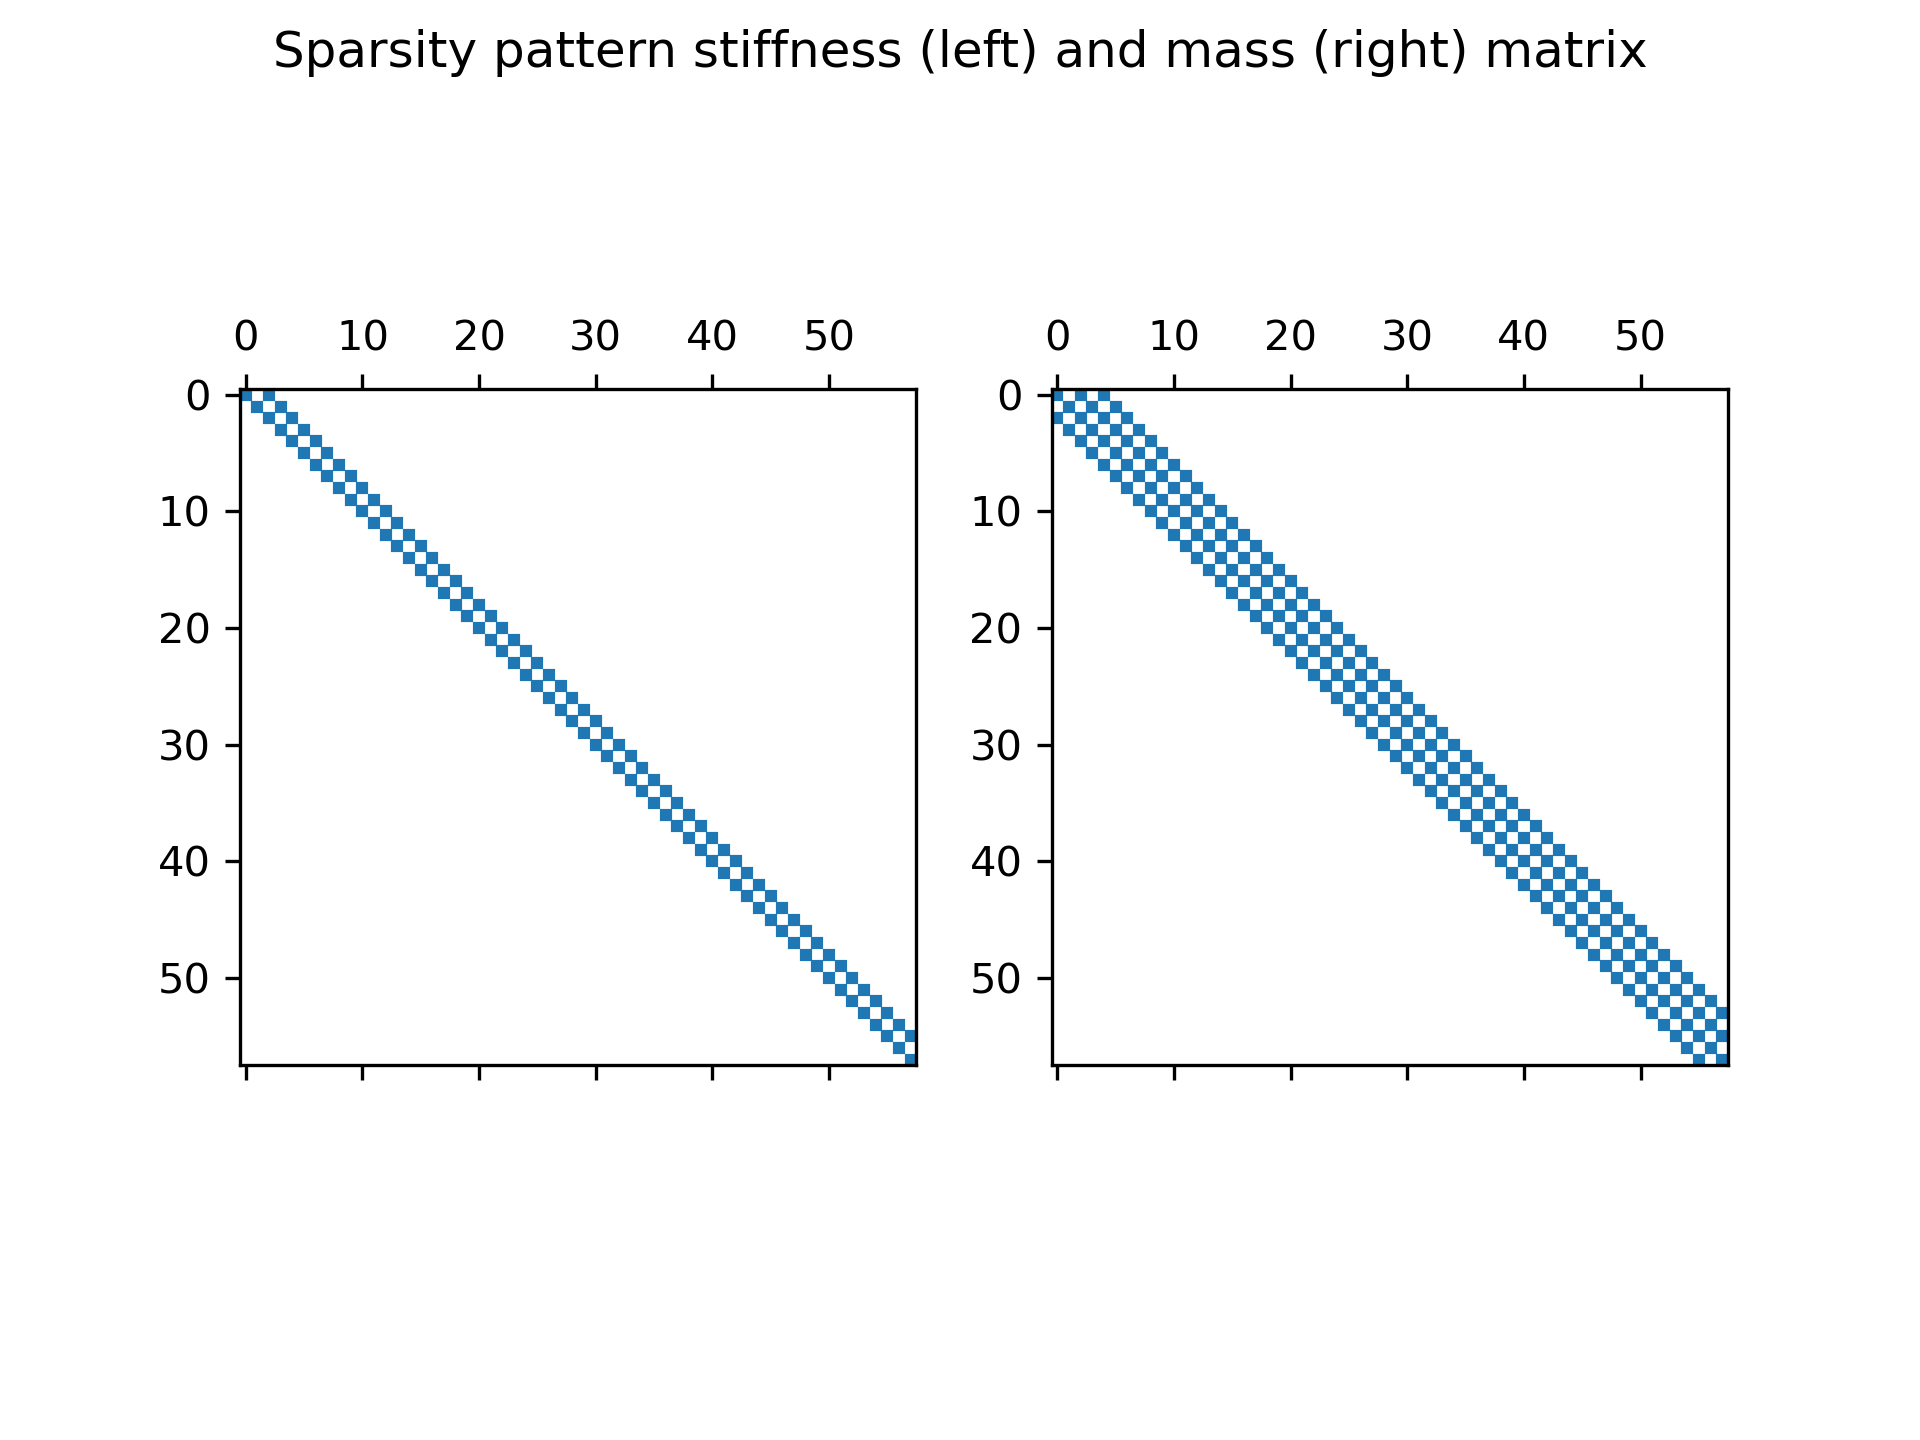

Text(0.5, 0.98, 'Sparsity pattern stiffness (left) and mass (right) matrix')

In [4]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.spy(A[0].diags(), ms=2)
ax2.spy(A[1].diags(), ms=2)
fig.suptitle('Sparsity pattern stiffness (left) and mass (right) matrix')

# Condition numbers

Check the condition number of the coefficient matrix. Use a relatively low number since Jacobi is not implemented very robustly, with gamma functions that overflow. Also, Numpy's routine for computing the condition number makes use of dense matrices, which limits the size. An alternative sparse option here is to compute the eigenvalues with [scipy.sparse.linalg.eigs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html).

In [5]:
def cond(N, family='Chebyshev', alpha=0):
    """Return condition number of Helmholtz coefficient matrix
    
    Parameters
    ----------
    N : int
        The number of quadrature points. For a Dirichlet space there is N-2 dofs.
    family : str, optional
        Either one of
        - 'Chebyshev'      (or 'C')
        - 'ChebyshevU'     (or 'U') 
        - 'Legendre'       (or 'L')
        - 'Ultraspherical' (or 'Q')
    alpha : number, optional
        Parameters used only by the Ultraspherical family
    """
    assert N < 1000
    S = FunctionSpace(N, family, bc=(0, 0), alpha=alpha)
    V = FunctionSpace(N+2, family, basis='Phi2', alpha=alpha)
    u = TrialFunction(S)
    v = TestFunction(V)
    A = inner(v, div(grad(u)) - mu*u)
    M = np.sum(np.array(A, dtype=object)).diags()
    return np.linalg.cond(M.toarray())

Run over all families and compute the condition numbers for a range of matrix sizes.

In [6]:
alpha = 0.5
con = {'C': [], 'L': [], 'U': [], 'Q': []}
for family in 'CULQ':
    for n in range(3, 8):
        con[family].append(cond(2**n, family, alpha)) # alpha neglected by C, U, L

Plot the condition numbers using loglog axes to show that Chebyshev, Legendre and any ultraspherical basis using scaling $g_n^{\alpha}=(P^{(\alpha,\alpha)}_n(1))^{-1}$ obtain condition numbers that are $\mathcal{O}(N)$, whereas Chebyshev of the second kind (which uses a slightly different scaling) obtain condition numbers scaling as $\mathcal{O}(N^{3/2})$. Note that a ultraspherical basis with $\alpha=1/2$ results in $\mathcal{O}(N)$. 

<IPython.core.display.Javascript object>


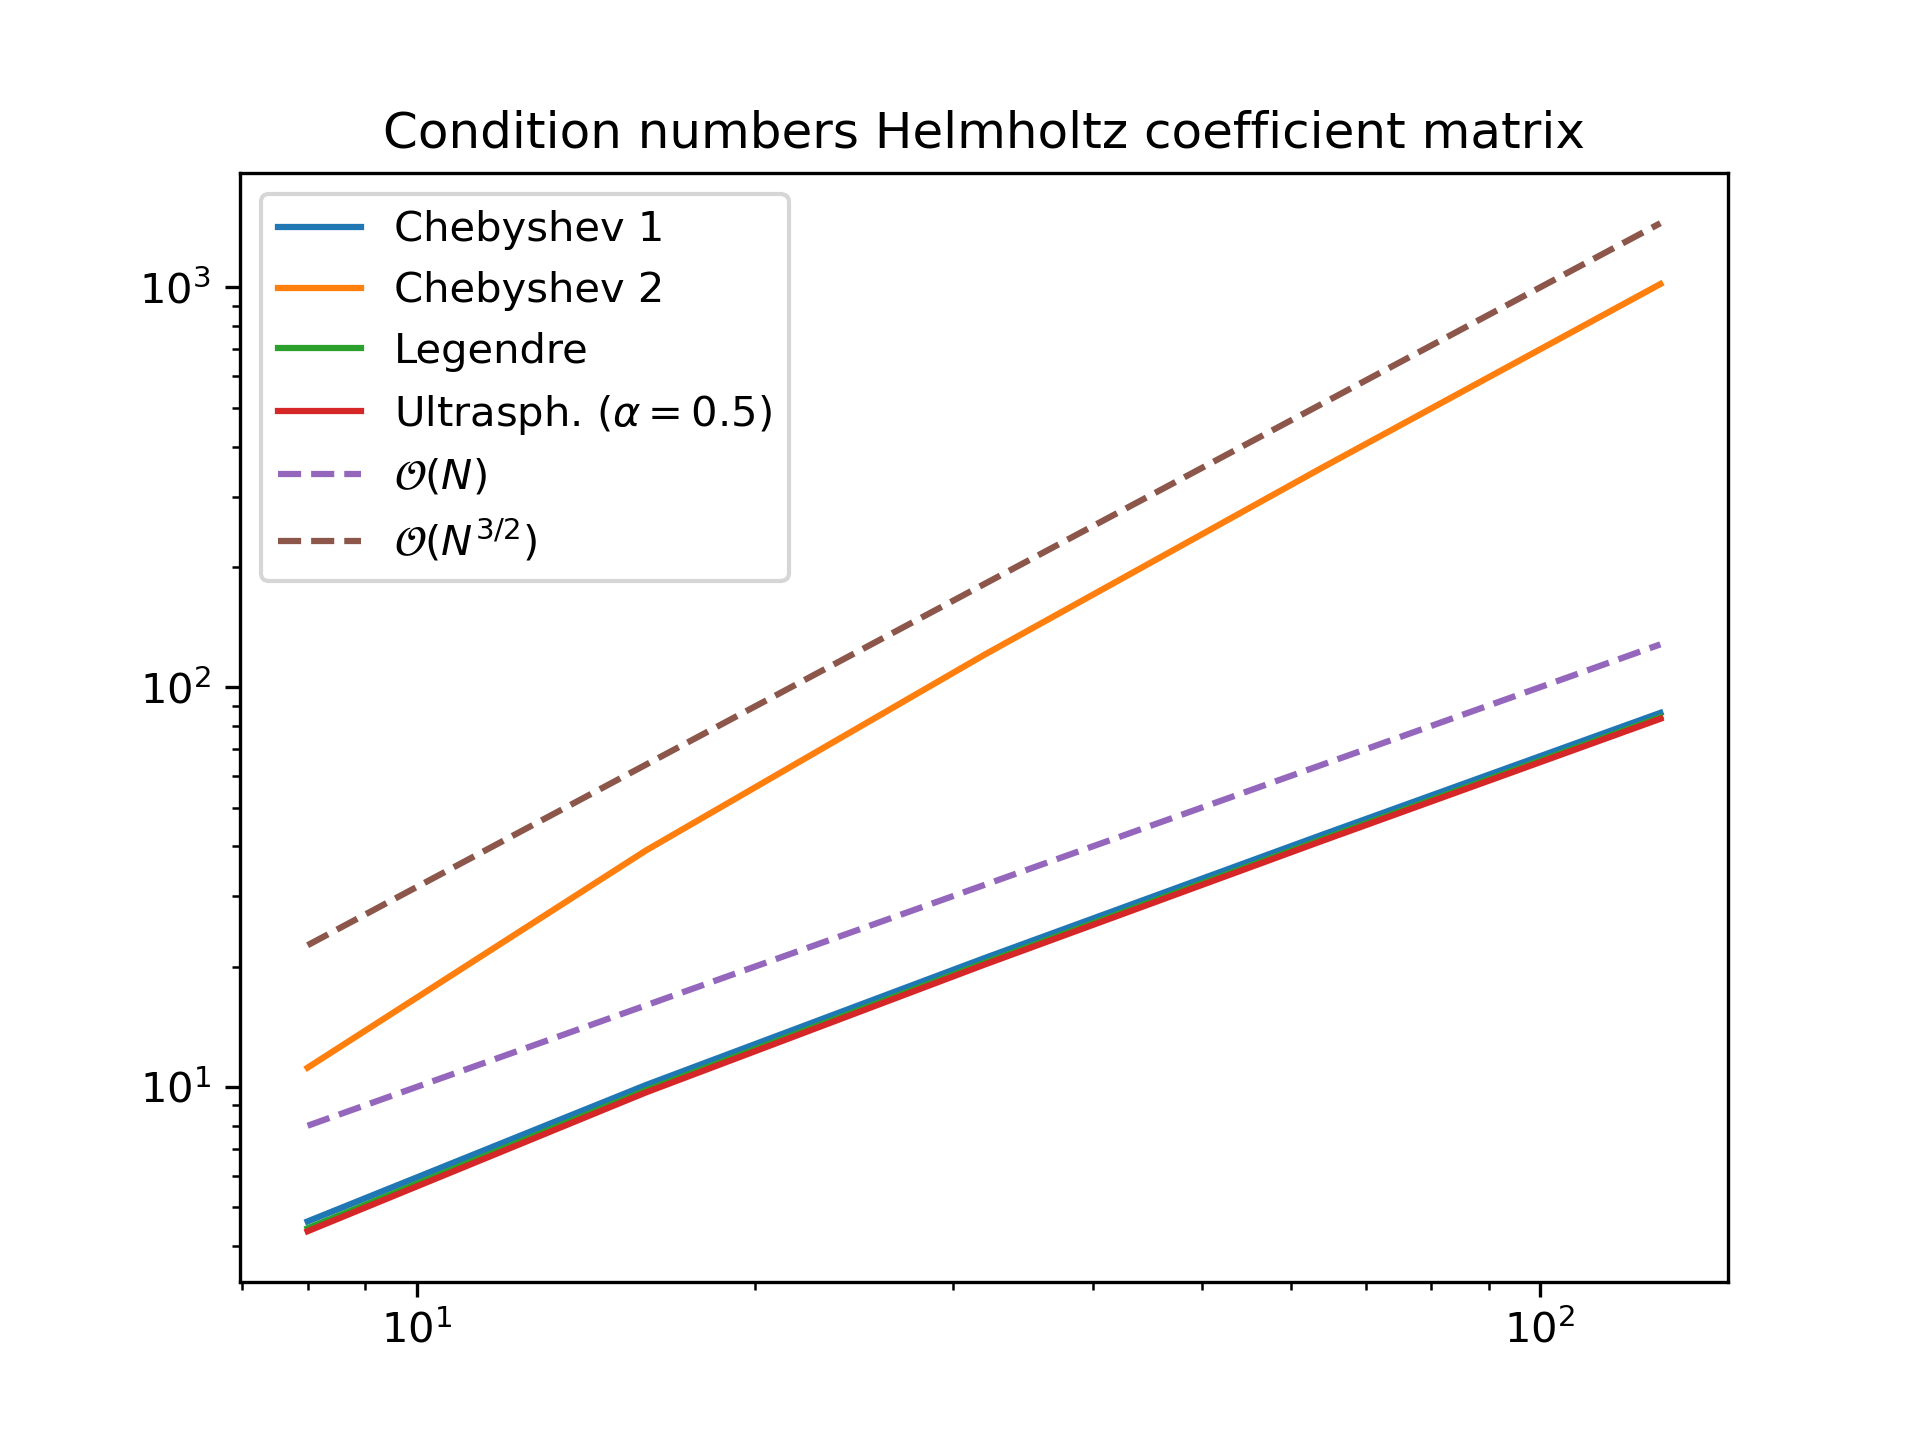

In [7]:
plt.figure()
for family in 'CULQ':
    plt.loglog(2**np.array(range(3, 8)), con[family])

plt.loglog(2**np.array(range(3, 8)), 2**np.array(range(3, 8)), '--')
plt.loglog(2**np.array(range(3, 8)), (2**np.array(range(3, 8)))**1.5, '--')
plt.legend(['Chebyshev 1', 'Chebyshev 2', 'Legendre', rf'Ultrasph. $(\alpha={alpha})$', r'$\mathcal{O}(N)$', r'$\mathcal{O}(N^{3/2})$'])
plt.title('Condition numbers Helmholtz coefficient matrix')
plt.show()